In [257]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sympy.solvers import solve
from sympy import Symbol
from scipy.optimize import fsolve
from scipy.optimize import least_squares
from tkinter import Tk
import customtkinter as CTk
from tkinter.filedialog import askopenfile
import helpers
from scipy.optimize import least_squares

In [339]:
class ITC_model():
    
    
    def __init__(self , name , eqn , species_formed , dissociation_constants , dH , formula):
        
        # This step defines the model
        
        self.name = name
        self.equations = [ele.replace(' ' , '') for ele in eqn.split(';')]
        self.species_formed = [ele.replace(' ' , '') for ele in species_formed.split(';')]
        self.Kds = np.float64([ele.replace(' ' , '') for ele in dissociation_constants.split(';')])
        self.dH = np.float64([ele.replace(' ' , '') for ele in dH.split(';')])
        self.formula = [tuple(ele.replace(' ' , '').split(';')) for ele in formula]
        
        self.update_formula()
        
    def split(self , s):
        
        '''
        
        Given the string this function splits it into different elements based on mathematical operators
        Example: 
            Input: 
                a + b - c / e * (a + b)
            Output: 
                1. [a , b , c , e , a , b]
                2. [+ , - , / , *( , + , )]
        
        '''
        
        lst1 = list()
        lst2 = list()
        
        operators = ['+' , '-' , '*' , '/' , '**' , '(' , ')']
        
        last_option = None
        
        for i in range(len(s)):
            
            if s[i] in operators:
                
                if last_option != 'Operator':
                    
                    lst2.append(s[i])
                    last_option = 'Operator'
                    
                else:
                    
                    lst2[-1] = lst2[-1] + s[i]
                    
            else:
                
                if last_option != 'Variable':
                    
                    lst1.append(s[i])
                    last_option = 'Variable'
                    
                else:
                    
                    lst1[-1] = lst1[-1] + s[i]
                
        
        return lst1 , lst2  
        
    def update_formula(self):
        
        # This method changes formula in such a way that it can be used by eval function
        
        final_formula = list()
        
        lst = ['Rtotal' , 'Ltotal']
        
        for ele in self.formula:
            
            f = ele[0]
            
            lst1 , lst2 = self.split(f)
            
            for i in range(len(lst1)):
                
                if lst1[i] in lst:
                    
                    lst1[i] = 'self.' + lst1[i]
                    continue
                    
                elif 'Kd' in lst1[i]:
                    
                    lst1[i] = 'self.Kds[\'' + lst1[i] + '\']'
                    
                elif lst1[i] == ele[1]:
                    
                    if ele[2] == 'Numeric':
                    
                        lst1[i] = 'x'
                        continue
                        
                    else:
                        
                        lst1[i] = 'Symbol(\'x\')'
                        continue
                    
                elif (lst1[i] in ['R' , 'L'] or lst1[i] in self.species_formed) and lst1[i] != ele[1]:
                    
                    lst1[i] = 'self.conc[\'' + lst1[i] + '\']'
            
            s = lst1[0]
            
            for i in range(len(lst2)):
                
                s = s + lst2[i] + lst1[i + 1]
        
            final_formula.append((s , ele[1] , ele[2]))
        
        self.formula = final_formula
        
    def display(self):
        
        # This function is to display the information about the model
        
        print('Model: ' ,  self.name)
        
        # Equations
        
        print('Equations: ')
        
        for i in range(len(self.equations)):
            
            print(str(i+1) + '. ' + self.equations[i])
            
        # Species produced
        
        print('Species formed: ')
        
        for i in range(len(self.species_formed)):
            
            print(str(i+1) + '. ' + self.species_formed[i])
            
        # Kds
        
        print('Dissociation constants: ')
        
        for i in range(len(self.Kds)):
            
            print(str(i+1) + '. Kd' + str(i+1) + ' = ' + str(self.Kds[i]))
            
        # Formula
        
        print('Formula: ')
            
        for i in range(len(self.formula)):
            
            print(str(i+1) + '. ' + self.formula[i][0] + '; ' +  self.formula[i][1] + '; ' +  self.formula[i][2])
        

In [340]:
eqn = 'R + l -> RL'
species_formed = 'RL'
dissociation_constants = '1e-8'
dH = '-2'
formula = ['RL**2 - RL*(Ltotal + Rtotal + Kd1) + Rtotal*Ltotal; RL ; Numeric']


g = ITC_model('UR2' , eqn , species_formed , dissociation_constants , dH , formula)

g.display()

Model:  UR2
Equations: 
1. R+l->RL
Species formed: 
1. RL
Dissociation constants: 
1. Kd1 = 1e-08
Formula: 
1. x**2-x*(self.Ltotal+self.Rtotal+self.Kds['Kd1'])+self.Rtotal*self.Ltotal; RL; Numeric


In [468]:
eqn = 'R + l -> RL ; R + R -> R2'
species_formed = 'RL; R2'
dissociation_constants = '1e-8 ; 5e-3'
dH = '-2 ; 1'
formula = ['Rtotal - Kd1 * (Ltotal - L) / L - (Ltotal - L) - 2 * (1/Kd2) * (Kd1 * (Ltotal - L) / L) ** 2 ; L ; Numeric'  , 'RL - Ltotal + L ; RL ; Numeric' , 'R - Kd1 * RL / L ; R ; Numeric' , 'R2 - R * R / Kd2 ; R2 ; Numeric']

g = ITC_model('UR2' , eqn , species_formed , dissociation_constants , dH , formula)

g.display()

Model:  UR2
Equations: 
1. R+l->RL
2. R+R->R2
Species formed: 
1. RL
2. R2
Dissociation constants: 
1. Kd1 = 1e-08
2. Kd2 = 0.005
Formula: 
1. self.Rtotal-self.Kds['Kd1']*(self.Ltotal-x)/x-(self.Ltotal-x)-2*(1/self.Kds['Kd2'])*(self.Kds['Kd1']*(self.Ltotal-x)/x)**2; L; Numeric
2. x-self.Ltotal+self.conc['L']; RL; Numeric
3. x-self.Kds['Kd1']*self.conc['RL']/self.conc['L']; R; Numeric
4. x-self.conc['R']*self.conc['R']/self.Kds['Kd2']; R2; Numeric


In [469]:
class ITC_simulation():
    
    def __init__(self , model):
        
        self.model = model
        self.LRratio = [1.0e-3]
        [self.LRratio.append(ele) for ele in np.linspace(0.1 , 1.4 , 1400)]
        self.Rtotal = 1.0e-3
        self.Ltotal = None
        self.Kds = dict()
        self.formula = self.model.formula
        self.conc_list = {'L' : [] , 'R' : []}
        for i in range(len(self.model.Kds)):
            
            self.Kds['Kd' + str(i + 1)] = self.model.Kds[i]
            
        self.conc = {'L' : None , 'R' : None}
        
        for molecule in self.model.species_formed:
            
            self.conc[molecule] = None
            self.conc_list[molecule] = []
    
    def func(self , x , f):
        
        return eval(f)
    
    def get_value(self , temp):
        
        print(type(temp))
        
        if type(temp) == dict:
            
            return list(temp.values())[0]
        
        else:
            
            return temp[0]
    
    def simulate(self):
        
        plt.figure()
        
        for ratio in self.LRratio:
            
            self.Ltotal = ratio * self.Rtotal
            
            for f in self.formula:
                
                if f[2] == 'Numeric':
                    
                    self.conc[f[1]] = least_squares(self.func , args = (f[0] , ) , x0 = 0.9 * self.Ltotal, bounds = (0 , self.Ltotal) , method = 'dogbox').x
                    
                    
                else:
                    
                    temp = solve(eval(f[0]) , Symbol('x') , dict = False)
                    
                    self.conc[f[1]] = self.get_value(temp)
                    
                    #print(f[1] , self.conc[f[1]] , f[0])
                    
                    #self.conc[f[1]] = list(self.conc[f[1]].values())[0]
                    
                self.conc_list[f[1]].append(self.conc[f[1]] / self.Rtotal)

In [470]:
H = ITC_simulation(g)

In [471]:
H.formula[0][0]

"self.Rtotal-self.Kds['Kd1']*(self.Ltotal-x)/x-(self.Ltotal-x)-2*(1/self.Kds['Kd2'])*(self.Kds['Kd1']*(self.Ltotal-x)/x)**2"

In [472]:
H.simulate()

<string>:1: RuntimeWarning: divide by zero encountered in true_divide


<Figure size 432x288 with 0 Axes>

L
R
RL
R2


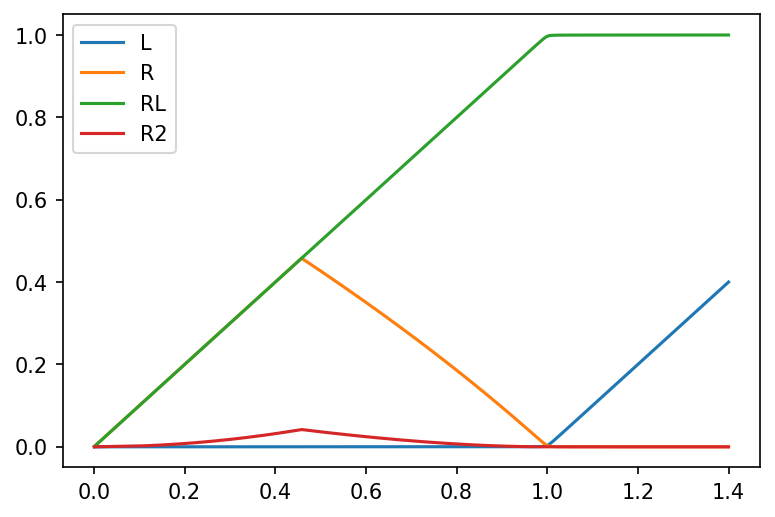

In [473]:
plt.figure(dpi = 150)

for ele in H.conc_list:
    
    print(ele)
    plt.plot(H.LRratio , H.conc_list[ele] , label = ele)
    
plt.legend()

In [478]:
eval('x - 5' , 'x')

TypeError: globals must be a real dict; try eval(expr, {}, mapping)